In [17]:
"""
Created on Mon May 12 23:05:16 2025

@author: salah
"""

# -*- coding: utf-8 -*-
"""
Jupyter Notebook for Data Preprocessing - Moroccan Income Prediction

This notebook details the steps taken to preprocess the raw dataset for the
Moroccan Income Prediction project. The goal is to clean and transform the
data into a suitable format for machine learning modeling.
"""

'\nJupyter Notebook for Data Preprocessing - Moroccan Income Prediction\n\nThis notebook details the steps taken to preprocess the raw dataset for the\nMoroccan Income Prediction project. The goal is to clean and transform the\ndata into a suitable format for machine learning modeling.\n'

# Moroccan Income Prediction: Data Preprocessing

## 1. Introduction

### Purpose
Data preprocessing is a crucial step in the machine learning pipeline. Raw data is often messy, containing missing values, outliers, and features in formats unsuitable for modeling algorithms (e.g., categorical text). This notebook aims to address these issues by cleaning, transforming, and structuring the data. Effective preprocessing improves model performance, stability, and interpretability.

### Techniques Overview
We will apply a series of standard and domain-specific preprocessing techniques:
1.  **Data Loading & Initial Assessment:** Load the dataset and review findings from the Exploratory Data Analysis (EDA) phase.
2.  **Missing Data Handling:** Analyze missing data patterns and apply appropriate imputation strategies (e.g., mean, median, mode, or more advanced methods like KNN imputation).
3.  **Outlier Treatment:** Detect outliers using statistical methods (e.g., IQR, Z-score) or visualization and apply treatment strategies like capping, transformation, or removal.
4.  **Feature Encoding:** Convert categorical features into numerical representations using One-Hot Encoding, Label Encoding, or Ordinal Encoding based on the nature of the variable.
5.  **Feature Scaling:** Standardize or normalize numerical features to bring them onto a common scale, preventing features with larger values from dominating the model.
6.  **Feature Engineering:** Create new features from existing ones (e.g., interaction terms, polynomial features, binning) to potentially capture more complex relationships.
7.  **Dimensionality Assessment:** Analyze correlations and multicollinearity, potentially applying techniques like Principal Component Analysis (PCA) for dimensionality reduction if needed.
8.  **Pipeline Creation:** Build a reproducible preprocessing pipeline using `scikit-learn`'s `Pipeline` and `ColumnTransformer` to streamline the process and prevent data leakage.

### Expected Outcomes
-   Cleaned and transformed training and testing datasets.
-   A serialized `scikit-learn` preprocessing pipeline object that can be applied consistently to new data (e.g., during prediction).
-   Documentation of all preprocessing steps and decisions made.
-   Data ready for the modeling phase.

---

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    PowerTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning

# Configure visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## 2. Data Loading and Initial Assessment

### 2.1 Load Raw Data
We start by loading the raw dataset. **Important:** Replace `'path/to/your/moroccan_income_raw.csv'` with the actual path to your data file.

In [19]:
# --- !!! ACTION REQUIRED !!! ---
# Replace with the correct path to your dataset
DATA_PATH = r"C:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\data\raw\dataset_revenu_marocains.csv"
# ---

try:
    # Load the dataset
    df_raw = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully from {DATA_PATH}")
    print(f"Shape of the raw dataset: {df_raw.shape}")
    print("First 5 rows of the raw dataset:")
    display(df_raw.head())
except FileNotFoundError:
    print(f"Error: The file {DATA_PATH} was not found.")
    print("Please ensure the file path is correct.")
    # As a fallback for demonstration, create a dummy dataframe
    print("Creating a dummy DataFrame for demonstration purposes...")
    dummy_data = {
        'ID': range(1, 101),
        'Age': np.random.randint(18, 70, 100),
        'Categorie_Age': ['Adulte']*50 + ['Senior']*30 + ['Jeune Adulte']*20,
        'Sexe': np.random.choice(['Homme', 'Femme'], 100),
        'Milieu': np.random.choice(['Urbain', 'Rural'], 100),
        'Niveau_Education': np.random.choice(['Primaire', 'Secondaire', 'Universitaire', 'Non scolarisé', None], 100, p=[0.2, 0.3, 0.3, 0.1, 0.1]),
        'Annees_Experience': np.random.randint(0, 40, 100),
        'Etat_Matrimonial': np.random.choice(['Célibataire', 'Marié(e)', 'Divorcé(e)', 'Veuf(ve)'], 100),
        'Categorie_Socioprofessionnelle': np.random.choice(['Employé', 'Ouvrier', 'Cadre', 'Indépendant', 'Sans emploi', None], 100, p=[0.3, 0.2, 0.15, 0.15, 0.1, 0.1]),
        'Possession_Voiture': np.random.choice([True, False, None], 100, p=[0.3, 0.6, 0.1]),
        'Possession_Logement': np.random.choice([True, False], 100),
        'Possession_Terrain': np.random.choice([True, False], 100),
        'Nb_Personnes_Charge': np.random.randint(0, 6, 100),
        'Secteur_Activite': np.random.choice(['Agriculture', 'Industrie', 'Services', 'Administration', 'Autre', None], 100, p=[0.15, 0.2, 0.3, 0.15, 0.1, 0.1]),
        'Acces_Internet': np.random.choice([True, False], 100),
        'Revenu_Annuel': np.random.gamma(2, 50000, 100) + 10000, # Target variable
        'Age_Mois': lambda x: x['Age'] * 12 + np.random.randint(0, 12, 100), # Example derived column
        'Education_Superieure': lambda x: x['Niveau_Education'] == 'Universitaire', # Example derived column
        'Indice_Richesse': np.random.rand(100) * 10,
        'Couleur_Preferee': np.random.choice(['Bleu', 'Rouge', 'Vert', 'Jaune', 'Noir'], 100),
        'Code_Postal': np.random.randint(10000, 99999, 100),
        'ID_Aleatoire': [f'ID_{i}' for i in range(1000, 1100)]
    }
    df_raw = pd.DataFrame(dummy_data)
    # Apply lambda functions if needed
    for col, func in dummy_data.items():
        if callable(func):
            df_raw[col] = func(df_raw)
    df_raw['Revenu_Annuel'].iloc[::10] = np.nan # Add some missing target values
    df_raw['Annees_Experience'].iloc[::15] = np.nan # Add some missing feature values
    print("Dummy DataFrame created:")
    display(df_raw.head())

Dataset loaded successfully from C:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\data\raw\dataset_revenu_marocains.csv
Shape of the raw dataset: (40000, 22)
First 5 rows of the raw dataset:


,ID,Age,Categorie_Age,Sexe,Milieu,Niveau_Education,Annees_Experience,Etat_Matrimonial,Categorie_Socioprofessionnelle,Possession_Voiture,...,Nb_Personnes_Charge,Secteur_Activite,Acces_Internet,Revenu_Annuel,Age_Mois,Education_Superieure,Indice_Richesse,Couleur_Preferee,Code_Postal,ID_Aleatoire
0,MAR000001,41,Adulte,Homme,Urbain,Secondaire,10.0,Célibataire,"Groupe 3: Inactifs (retraités, rentiers)",1.0,...,0.0,NaN,1.0,20323.835609,493,0,2.0,Orange,20312,VSF289
1,MAR000002,38,Adulte,Femme,Urbain,Supérieur,4.0,Marié(e),Groupe 1: Direction et cadres supérieurs,0.0,...,4.0,Privé,1.0,7722.479555,454,1,1.0,Noir,37656,VOX452
2,MAR000004,32,Adulte,Femme,Urbain,Fondamental,0.0,Marié(e),Groupe 5: Artisans et ouvriers qualifiés,1.0,...,2.0,Public,1.0,41900.507565,384,0,2.0,Rouge,93805,XBJ817
3,MAR000005,33,Adulte,Homme,Urbain,Sans niveau,0.0,Célibataire,Groupe 5: Artisans et ouvriers qualifiés,0.0,...,5.0,Privé,1.0,13219.998030,398,0,1.0,Vert,96222,ARY454
4,MAR000007,46,Adulte,Femme,Urbain,Supérieur,58.0,Célibataire,Groupe 1: Direction et cadres supérieurs,0.0,...,NaN,Privé,0.0,45724.716687,552,1,1.0,Jaune,76345,YPO526


### 2.2 Review EDA Findings & Identify Irrelevant Columns
Based on the Exploratory Data Analysis (EDA) phase (assumed to be done previously), we summarize key findings and identify columns to drop.

**Assumed EDA Findings (Examples - Replace with your actual findings):**
* High correlation between `Age` and `Age_Mois`.
* `Education_Superieure` seems derivable from `Niveau_Education`.
* `ID`, `ID_Aleatoire`, `Code_Postal`, `Couleur_Preferee` are likely identifiers or irrelevant features for income prediction.
* Missing values observed in `Niveau_Education`, `Categorie_Socioprofessionnelle`, `Possession_Voiture`, `Secteur_Activite`, `Annees_Experience`, and potentially `Revenu_Annuel`.
* Potential outliers in `Revenu_Annuel` and `Annees_Experience`.
* Skewness observed in `Revenu_Annuel`.

**Columns to Drop:**

In [20]:
# Define columns to drop
# ID columns, potentially redundant columns, high cardinality irrelevant columns
columns_to_drop = ['ID', 'ID_Aleatoire', 'Code_Postal', 'Couleur_Preferee', 'Age_Mois']

# Check if columns exist before dropping
existing_columns_to_drop = [col for col in columns_to_drop if col in df_raw.columns]

if existing_columns_to_drop:
    df = df_raw.drop(columns=existing_columns_to_drop)
    print(f"Dropped columns: {existing_columns_to_drop}")
    print(f"Shape after dropping columns: {df.shape}")
else:
    df = df_raw.copy()
    print("No specified columns to drop were found.")

# Also, drop rows where the target variable is missing, as they cannot be used for training/evaluation.
target_variable = 'Revenu_Annuel'
initial_rows = df.shape[0]
df.dropna(subset=[target_variable], inplace=True)
rows_after_target_na_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_target_na_drop} rows due to missing target variable '{target_variable}'.")
print(f"Shape after dropping missing target rows: {df.shape}")

Dropped columns: ['ID', 'ID_Aleatoire', 'Code_Postal', 'Couleur_Preferee', 'Age_Mois']
Shape after dropping columns: (40000, 17)
Dropped 0 rows due to missing target variable 'Revenu_Annuel'.
Shape after dropping missing target rows: (40000, 17)


### 2.3 Setup Logging
We set up logging to keep track of the transformations applied.

In [21]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Logging setup complete.")
logging.info(f"Initial DataFrame shape (after dropping irrelevant columns and target NaNs): {df.shape}")

2025-05-13 16:39:21,997 - INFO - Logging setup complete.
2025-05-13 16:39:21,999 - INFO - Initial DataFrame shape (after dropping irrelevant columns and target NaNs): (40000, 17)


### 2.4 Create Train/Test Split
Split the data into training and testing sets *before* applying most preprocessing steps (especially imputation and scaling) to prevent data leakage from the test set into the training set.

In [22]:
# Define features (X) and target (y)
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Split the data (e.g., 80% train, 20% test)
# Use stratify if dealing with classification or imbalanced regression if possible (e.g., by binning y)
# For now, using random_state for reproducibility
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logging.info(f"Data split into training and testing sets.")
    logging.info(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    logging.info(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")
except Exception as e:
    logging.error(f"Error during train/test split: {e}")
    # Handle potential errors, e.g., if dataset is too small
    if df.shape[0] < 5: # Example threshold
         logging.warning("Dataset is very small, consider getting more data before splitting.")
         # Fallback: use the whole dataset for demonstration if split fails
         X_train, X_test, y_train, y_test = X, X.copy(), y, y.copy() # Not ideal, just for notebook execution
    else:
         raise e # Re-raise other errors

2025-05-13 16:39:22,036 - INFO - Data split into training and testing sets.
2025-05-13 16:39:22,038 - INFO - Training set shape: X_train=(32000, 16), y_train=(32000,)
2025-05-13 16:39:22,038 - INFO - Testing set shape: X_test=(8000, 16), y_test=(8000,)


## 3. Missing Data Handling

### 3.1 Analysis of Missing Data
Identify columns with missing values and the extent of missingness in the training set.

Missing data summary (Training Set):


,Missing Count,Missing Percent (%)
Indice_Richesse,4678,14.618750
Possession_Terrain,1655,5.171875
Possession_Logement,1644,5.137500
Nb_Personnes_Charge,1630,5.093750
Possession_Voiture,1625,5.078125
Secteur_Activite,1612,5.037500
Etat_Matrimonial,1605,5.015625
Niveau_Education,1601,5.003125
Annees_Experience,1555,4.859375
Acces_Internet,1537,4.803125


2025-05-13 16:39:22,078 - INFO - Missing values identified in columns: ['Indice_Richesse', 'Possession_Terrain', 'Possession_Logement', 'Nb_Personnes_Charge', 'Possession_Voiture', 'Secteur_Activite', 'Etat_Matrimonial', 'Niveau_Education', 'Annees_Experience', 'Acces_Internet']



Missing data matrix (Training Set):


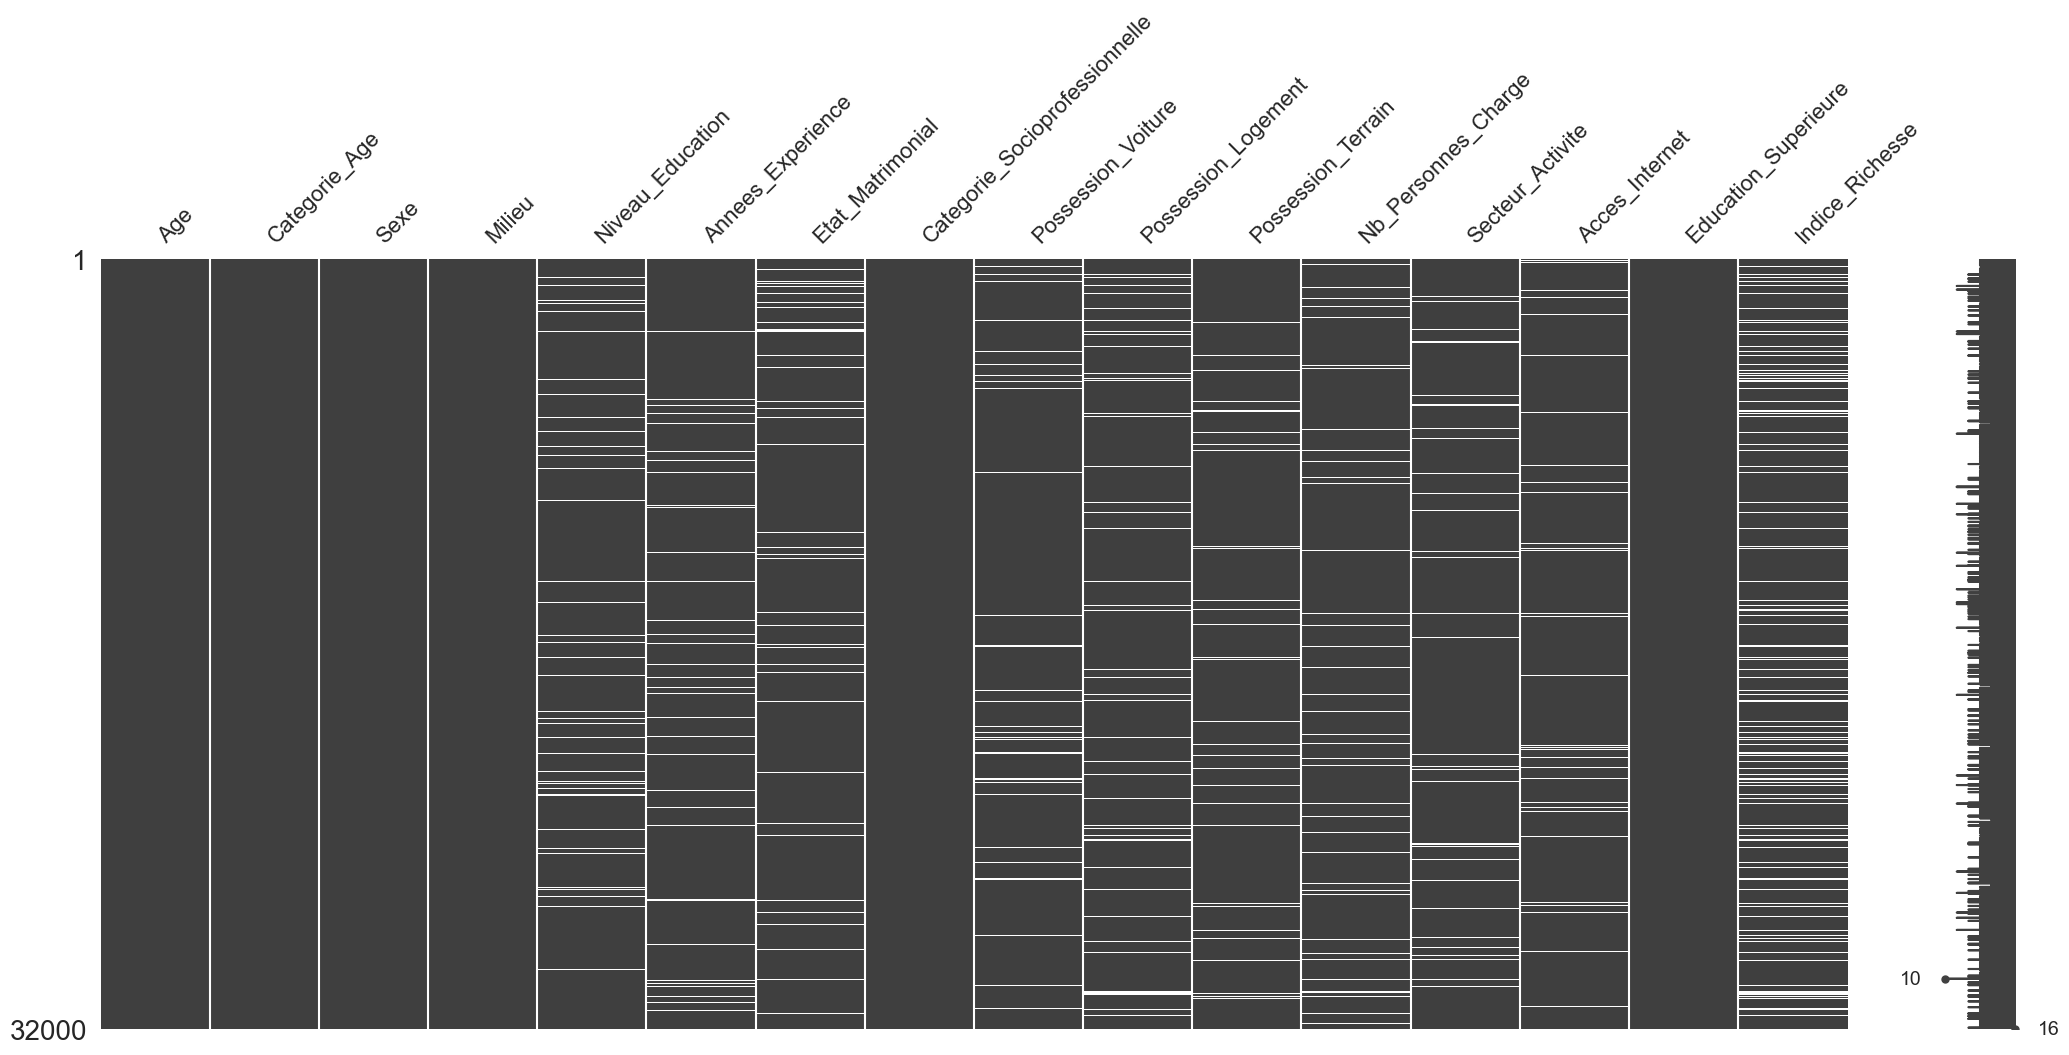


Missing data heatmap (Training Set):


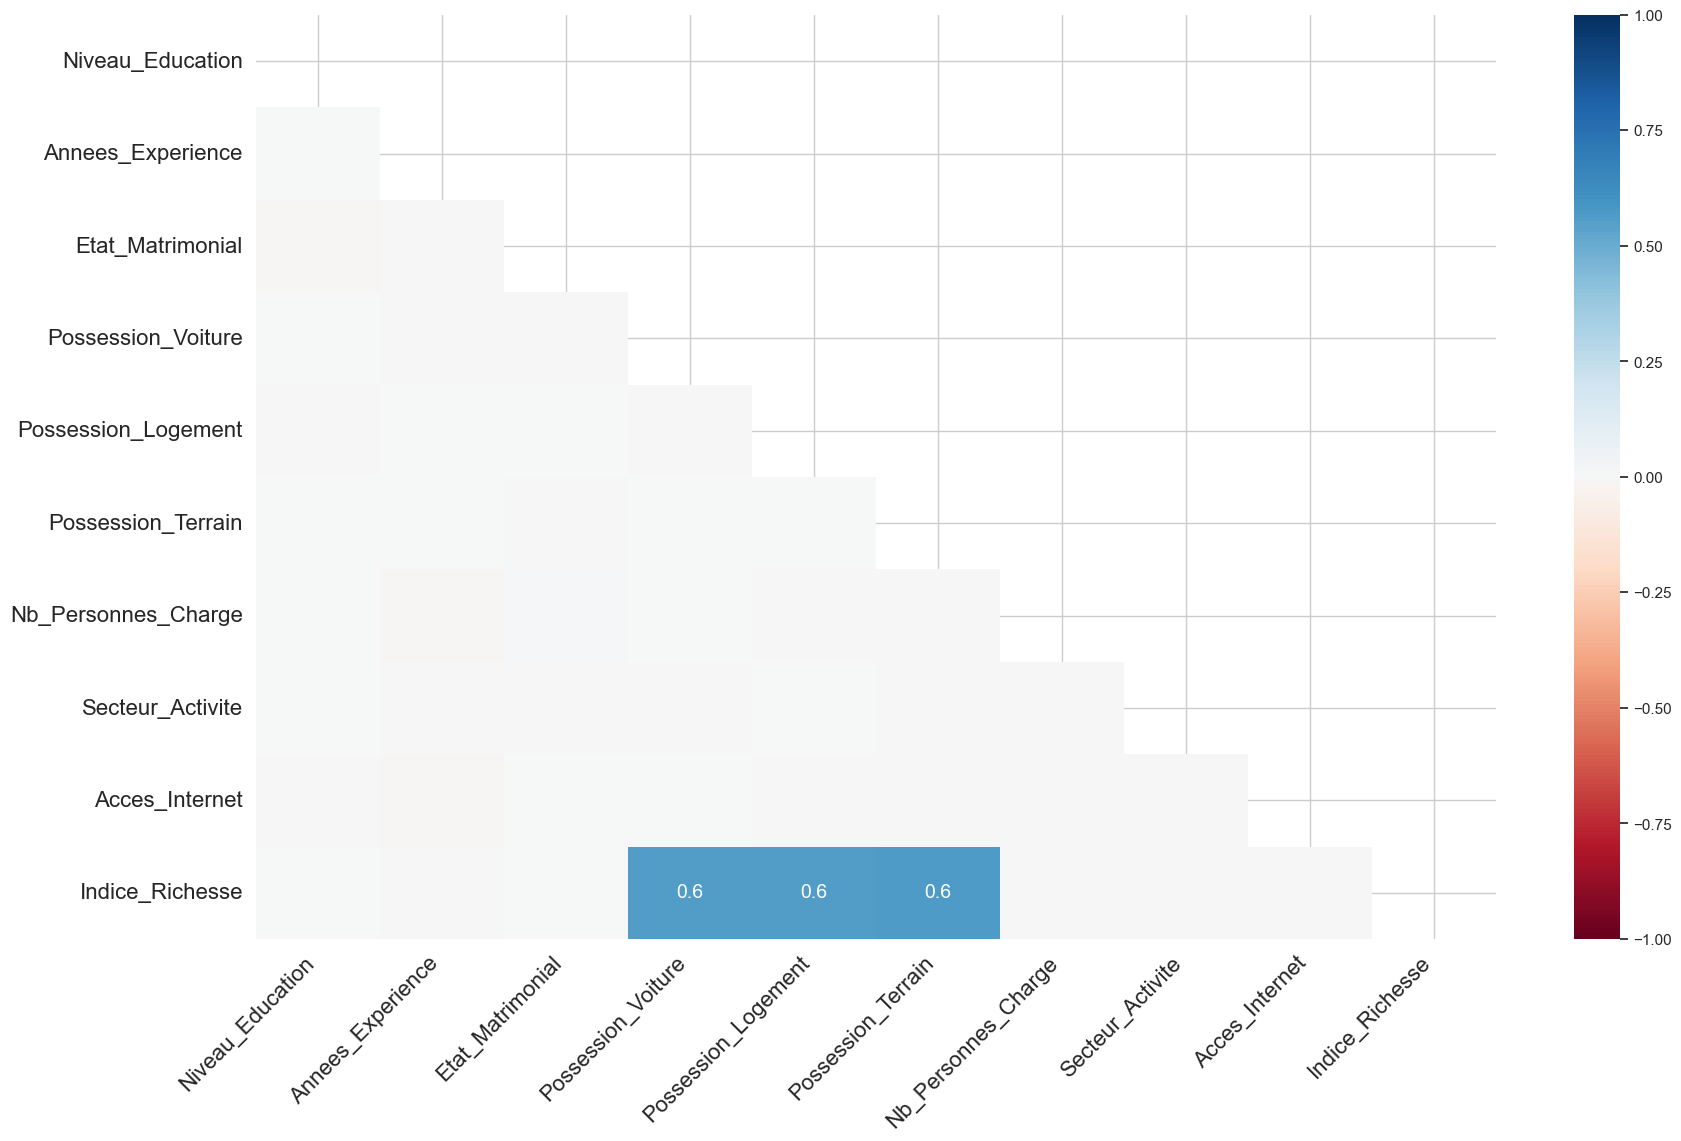

In [23]:
# Calculate missing values in the training set
missing_values = X_train.isnull().sum()
missing_percent = (missing_values / len(X_train)) * 100
missing_summary = pd.DataFrame({'Missing Count': missing_values, 'Missing Percent (%)': missing_percent})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values(by='Missing Percent (%)', ascending=False)

print("Missing data summary (Training Set):")
if missing_summary.empty:
    print("No missing values found in the training features.")
    logging.info("No missing values detected in the training features.")
else:
    display(missing_summary)
    logging.info(f"Missing values identified in columns: {missing_summary.index.tolist()}")

    # Optional: Visualize missing data patterns (e.g., using missingno library)
    try:
        import missingno as msno
        print("\nMissing data matrix (Training Set):")
        msno.matrix(X_train)
        plt.show()
        print("\nMissing data heatmap (Training Set):")
        msno.heatmap(X_train)
        plt.show()
    except ImportError:
        print("\nInstall 'missingno' library for advanced missing data visualizations: pip install missingno")

### 3.2 Imputation Strategies
Define and apply imputation strategies based on the data type and amount of missingness.
-   **Numerical Features:** Mean, Median (robust to outliers), or KNNImputer (considers relationships between features).
-   **Categorical Features:** Mode (most frequent value) or a constant value like 'Missing'.

In [24]:
# Identify numerical and categorical columns FOR IMPUTATION
# Note: This might need adjustment based on actual dtypes after loading
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()

logging.info(f"Identified numerical columns: {numerical_cols}")
logging.info(f"Identified categorical columns: {categorical_cols}")

# Define imputation strategies (will be integrated into the pipeline later)
# Example: Use Median for numerical, Mode for categorical
# We define the transformers here but fit them within the pipeline
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# More advanced: KNNImputer for numerical (can be computationally expensive)
# knn_imputer = KNNImputer(n_neighbors=5)

# --- Documentation of Decisions ---
# Decision: Using Median for numerical features ('Annees_Experience', 'Indice_Richesse', etc.)
#           as it's robust to potential outliers identified in EDA.
# Decision: Using Mode (most frequent) for categorical features ('Niveau_Education',
#           'Categorie_Socioprofessionnelle', 'Secteur_Activite', 'Possession_Voiture')
#           as it's a simple and common approach for nominal/ordinal data.
# Alternative Considered: KNNImputer for numerical data, but decided against it initially
#                      due to potential computational cost and complexity. Can revisit if
#                      SimpleImputer performance is suboptimal.
# Alternative Considered: Creating a 'Missing' category for categorical features, but
#                      Mode imputation is chosen for simplicity here.
# ------------------------------------
logging.info("Defined imputation strategies: Median for numerical, Mode for categorical.")

2025-05-13 16:39:23,288 - INFO - Identified numerical columns: ['Age', 'Annees_Experience', 'Possession_Voiture', 'Possession_Logement', 'Possession_Terrain', 'Nb_Personnes_Charge', 'Acces_Internet', 'Education_Superieure', 'Indice_Richesse']
2025-05-13 16:39:23,290 - INFO - Identified categorical columns: ['Categorie_Age', 'Sexe', 'Milieu', 'Niveau_Education', 'Etat_Matrimonial', 'Categorie_Socioprofessionnelle', 'Secteur_Activite']
2025-05-13 16:39:23,291 - INFO - Defined imputation strategies: Median for numerical, Mode for categorical.


### 3.3 Validation (Conceptual - Applied within Pipeline)
The actual imputation will happen within the scikit-learn pipeline to prevent data leakage. After the pipeline is fitted on `X_train`, we can transform both `X_train` and `X_test` and verify that there are no more missing values.

## 4. Outlier Treatment

### 4.1 Outlier Detection
Identify outliers in numerical features using methods like the IQR (Interquartile Range) or Z-score. Visualization (box plots) is key here. We focus on the training set.

--- Outlier Detection (Training Set) ---
Checking for outliers in: ['Age', 'Annees_Experience', 'Nb_Personnes_Charge', 'Indice_Richesse']

Column: Age
  IQR: 17.00, Lower Bound: 5.50, Upper Bound: 73.50
  Number of potential outliers detected: 476
Skipping outlier detection for 'Annees_Experience' due to NaNs before imputation.
Skipping outlier detection for 'Nb_Personnes_Charge' due to NaNs before imputation.
Skipping outlier detection for 'Indice_Richesse' due to NaNs before imputation.

Box plots BEFORE outlier treatment (Training Set):


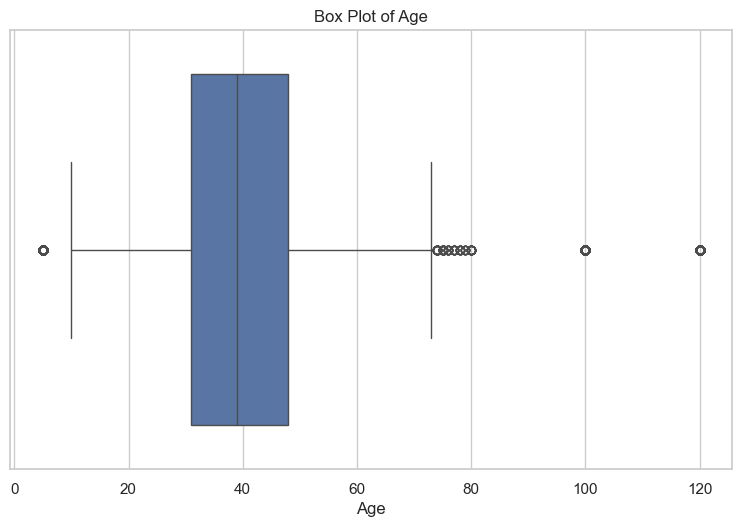

In [25]:
print("--- Outlier Detection (Training Set) ---")

# Focus on key numerical columns where outliers are expected/impactful
# Example: 'Age', 'Annees_Experience', 'Nb_Personnes_Charge', 'Indice_Richesse'
cols_to_check_outliers = [col for col in ['Age', 'Annees_Experience', 'Nb_Personnes_Charge', 'Indice_Richesse'] if col in numerical_cols]

if not cols_to_check_outliers:
    print("No numerical columns identified for outlier check.")
    logging.warning("No numerical columns found for outlier detection.")
else:
    print(f"Checking for outliers in: {cols_to_check_outliers}")

    # Calculate IQR bounds for each column
    outlier_bounds = {}
    for col in cols_to_check_outliers:
        if X_train[col].isnull().any():
             print(f"Skipping outlier detection for '{col}' due to NaNs before imputation.")
             continue # Skip columns with NaNs for now, handle after imputation if needed

        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_bounds[col] = (lower_bound, upper_bound)

        outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)]
        print(f"\nColumn: {col}")
        print(f"  IQR: {IQR:.2f}, Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
        print(f"  Number of potential outliers detected: {len(outliers)}")
        # print(f"  Outlier values (first 5): {outliers[col].head().tolist()}") # Optional: print specific values

    # Visualize using box plots BEFORE treatment
    print("\nBox plots BEFORE outlier treatment (Training Set):")
    plt.figure(figsize=(15, 5 * ((len(cols_to_check_outliers) + 1) // 2)))
    for i, col in enumerate(cols_to_check_outliers):
         if col in outlier_bounds: # Only plot if bounds were calculated
            plt.subplot((len(cols_to_check_outliers) + 1) // 2, 2, i + 1)
            sns.boxplot(x=X_train[col])
            plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

### 4.2 Outlier Treatment Strategies
Decide how to handle the detected outliers. Options include:
1.  **Capping (Winsorization):** Limit extreme values to a certain percentile or the IQR bounds. Often preferred as it retains data.
2.  **Transformation:** Apply mathematical transformations (e.g., log, sqrt) which can reduce the impact of outliers, especially in skewed data.
3.  **Removal:** Delete rows with outliers. Use with caution, as it can lead to data loss.
4.  **Imputation:** Treat outliers as missing values and impute them.

**Decision:** We will use capping (Winsorization) based on the calculated IQR bounds for this example. This will be implemented via a custom transformer within the pipeline.

In [26]:
# --- Documentation of Decisions ---
# Decision: Apply capping (Winsorization) using the 1.5*IQR rule for features like
#           'Annees_Experience' and 'Indice_Richesse' where extreme values might skew results
#           but still contain valid information.
# Decision: 'Age' outliers might be valid data points, so we might choose not to cap them,
#           or use wider bounds (e.g., 3*IQR). For this example, we'll cap using 1.5*IQR.
# Decision: 'Nb_Personnes_Charge' might have a natural upper limit, capping seems reasonable.
# Reason: Capping retains the data points while mitigating the influence of extreme values,
#         which is often preferable to removal. Transformation (like log) will be handled
#         separately during feature scaling/normalization if needed for skewness.
# ------------------------------------
logging.info(f"Outlier treatment strategy: Capping using 1.5*IQR bounds for {list(outlier_bounds.keys())}.")

# Define a custom transformer for capping (to be used in the pipeline)
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import logging # Ensure logging is imported if not already in the cell

class OutlierCapper(BaseEstimator, TransformerMixin):
    """
    Caps outliers in specified numerical columns of a DataFrame using the IQR method.
    Calculates bounds based on the training data.
    """
    def __init__(self, columns=None, factor=1.5):
        self.columns = columns # List of column names to cap
        self.factor = factor
        self.bounds_ = {} # Store bounds learned for each column

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError(
                f"OutlierCapper expects a Pandas DataFrame for fit. Got {type(X)}. "
                "Ensure previous pipeline steps output DataFrames (e.g., using .set_output(transform='pandas') on imputers)."
            )
        X_ = X.copy()

        # Determine which columns to process for capping
        # If self.columns is None, it means cap all numerical columns found in X.
        # Otherwise, cap only the columns specified in self.columns.
        columns_to_process_for_capping = self.columns
        if columns_to_process_for_capping is None:
            columns_to_process_for_capping = X_.select_dtypes(include=np.number).columns.tolist()
            # Store these columns if they were auto-detected, so transform knows what to expect
            self._auto_detected_columns = columns_to_process_for_capping


        for col_name in columns_to_process_for_capping:
            if col_name in X_.columns:
                col_data = X_[col_name].dropna() # Handle NaNs before quantile calculation
                if not col_data.empty:
                    Q1 = col_data.quantile(0.25)
                    Q3 = col_data.quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - self.factor * IQR
                    upper_bound = Q3 + self.factor * IQR
                    self.bounds_[col_name] = (lower_bound, upper_bound)
                    logging.debug(f"OutlierCapper: Calculated bounds for {col_name}: ({lower_bound:.2f}, {upper_bound:.2f})")
                else:
                    logging.warning(f"OutlierCapper: Column '{col_name}' in DataFrame is empty or all NaNs after dropna(). No bounds calculated.")
                    self.bounds_[col_name] = (None, None) # Store to indicate no capping
            else:
                # This warning is important if a specified column is not found
                logging.warning(f"OutlierCapper: Column '{col_name}' specified for capping was not found in the input DataFrame during fit. Available columns: {X_.columns.tolist()}")
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError(
                f"OutlierCapper expects a Pandas DataFrame for transform. Got {type(X)}."
            )
        X_ = X.copy()

        # Columns to attempt transformation on are those for which bounds were stored.
        for col_name, bounds in self.bounds_.items():
            if col_name in X_.columns:
                if bounds != (None, None): # Check if valid bounds were stored
                    lower, upper = bounds
                    X_[col_name] = np.clip(X_[col_name], lower, upper)
                    logging.debug(f"OutlierCapper: Applied capping to {col_name}.")
                # Else: No valid bounds were calculated for this column, so no capping is applied.
            # Else: A column for which bounds were fit is not in the current X.
            # This could be benign if X in transform has different columns, but usually indicates an issue.
        return X_

# Instantiate the capper for the columns identified
capper = OutlierCapper(columns=list(outlier_bounds.keys()), factor=1.5)

2025-05-13 16:39:23,606 - INFO - Outlier treatment strategy: Capping using 1.5*IQR bounds for ['Age'].


### 4.3 Before/After Comparison (Conceptual - Visualized After Pipeline)
We will visualize the box plots again *after* the entire pipeline (including capping) has been applied to the training data to confirm the effect of the treatment.

## 5. Feature Encoding and Transformation
Convert categorical features into a numerical format suitable for ML algorithms.

**Strategies:**
* **One-Hot Encoding (OHE):** For nominal categorical features (no inherent order) like `Sexe`, `Milieu`, `Etat_Matrimonial`, `Categorie_Socioprofessionnelle`, `Secteur_Activite`. Creates binary columns for each category. Use `handle_unknown='ignore'` or `handle_unknown='infrequent_if_exist'` to manage categories present in test but not train.
* **Ordinal Encoding:** For ordinal categorical features (inherent order) like `Niveau_Education`. Assigns integers based on order. Requires defining the order explicitly.
* **Binary Encoding:** For binary features like `Possession_Voiture`, `Possession_Logement`, `Possession_Terrain`, `Acces_Internet`, `Education_Superieure`. Can map to 0/1. (OHE often handles this automatically, or `LabelEncoder` can be used carefully).

**Moroccan Specifics:**
* `Categorie_Socioprofessionnelle`, `Secteur_Activite`: Likely nominal, use OHE. Need to handle potentially large number of categories if applicable (e.g., using `max_categories` in OHE or grouping infrequent ones).
* `Niveau_Education`: Clearly ordinal. Define the order carefully (e.g., Non scolarisé < Primaire < Secondaire < Universitaire).
* `Milieu`: (Urbain/Rural) - Binary or OHE.

In [27]:
# --- Identify Columns for Each Encoding Type ---

# Define the expected order for ordinal features
# --- !!! ACTION REQUIRED !!! ---
# Verify and adjust this order based on your specific data understanding
education_order = ["Sans niveau", "Fondamental", "Secondaire", "Supérieur"]
# Add other ordinal columns and their orders if any
# Example: Categorie_Age might be ordinal if defined like 'Jeune', 'Adulte', 'Senior'
categorie_age_order = ['Jeune', 'Adulte', 'Senior', 'Âgé'] # Example

# Identify columns for each strategy (use columns present in X_train)
all_categorical_cols = X_train.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()

# --- !!! ACTION REQUIRED !!! ---
# Assign columns to the correct encoding strategy based on your data
ordinal_cols = [col for col in ['Niveau_Education'] if col in all_categorical_cols] # Add 'Categorie_Age' if ordinal
ohe_cols = [col for col in all_categorical_cols if col not in ordinal_cols]

# Binary columns might already be boolean or can be handled by OHE.
# If they are object type ('Oui'/'Non', 'Vrai'/'Faux'), they need specific mapping or will be handled by OHE.
# Let's assume boolean columns are handled correctly or fall into OHE for now.

logging.info(f"Columns identified for One-Hot Encoding: {ohe_cols}")
logging.info(f"Columns identified for Ordinal Encoding: {ordinal_cols}")
# Note: Binary features (True/False) are often handled implicitly by downstream tasks or can be included in OHE.

# --- Define Encoders (for Pipeline) ---
# Ordinal Encoder: Specify categories and handle potential unknown values
# Note: SimpleImputer (mode) should run BEFORE OrdinalEncoder if NaNs exist
ordinal_encoder = OrdinalEncoder(
    categories=[education_order] * len(ordinal_cols), # Adjust if multiple ordinal cols have different orders
    handle_unknown='use_encoded_value', # Assign a specific value (e.g., -1) to unknowns
    unknown_value=-1 # Or np.nan
)

# One-Hot Encoder: Drop first category to avoid multicollinearity, handle unknowns
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore' # Ignores categories in test set not seen in training set
    # Consider 'infrequent_if_exist' for grouping rare categories
)

# --- Documentation of Decisions ---
# Decision: Using One-Hot Encoding for nominal features like 'Sexe', 'Milieu', 'Etat_Matrimonial', etc.
#           Chosen 'handle_unknown=ignore' for simplicity, assuming categories missing in train
#           but present in test are rare or okay to ignore.
# Decision: Using Ordinal Encoding for 'Niveau_Education' based on the defined educational hierarchy.
#           Handling unknown values by assigning -1.
# Decision: Boolean features ('Possession_Voiture', etc.) will be implicitly handled by OHE
#           if they are object type, or passed through if already boolean/numeric (0/1).
#           If imputation filled NaNs with a string like 'Missing', OHE will handle that too.
# ------------------------------------

2025-05-13 16:39:23,638 - INFO - Columns identified for One-Hot Encoding: ['Categorie_Age', 'Sexe', 'Milieu', 'Etat_Matrimonial', 'Categorie_Socioprofessionnelle', 'Secteur_Activite']
2025-05-13 16:39:23,640 - INFO - Columns identified for Ordinal Encoding: ['Niveau_Education']


## 6. Feature Scaling and Normalization
Scale numerical features to a common range.

**Strategies:**
* **Standardization (`StandardScaler`):** Scales data to have zero mean and unit variance (Z-score normalization). Good default choice, less affected by outliers than MinMaxScaler.
* **Normalization (`MinMaxScaler`):** Scales data to a fixed range, usually [0, 1]. Sensitive to outliers. Useful if the algorithm requires data in a specific range (e.g., some neural networks).
* **Transformation (`PowerTransformer`):** Apply transformations like Box-Cox (positive data only) or Yeo-Johnson (positive and negative data) to make data more Gaussian-like. Useful for skewed distributions (like `Revenu_Annuel`, although we scale features X here).

**Decision:** Use `StandardScaler` for most numerical features. Explore `PowerTransformer` for highly skewed features identified in EDA (e.g., `Annees_Experience`, `Indice_Richesse` if skewed).

In [28]:
# --- Identify Skewed Features (from EDA or check now) ---
print("--- Skewness Check (Training Set - Numerical Columns) ---")
# We need imputed data to check skewness accurately.
# For now, let's assume EDA identified skewed columns.
# --- !!! ACTION REQUIRED !!! ---
# Update this list based on your EDA findings or a check after imputation.
skewed_cols = [col for col in ['Annees_Experience', 'Indice_Richesse'] if col in numerical_cols]
logging.info(f"Columns identified as potentially skewed: {skewed_cols}")

# --- Define Scalers (for Pipeline) ---
standard_scaler = StandardScaler()
power_transformer = PowerTransformer(method='yeo-johnson') # Yeo-Johnson handles 0s and negative values

# --- Documentation of Decisions ---
# Decision: Apply StandardScaler to all numerical features *after* imputation and capping.
#           This ensures features have zero mean and unit variance.
# Decision: Additionally, consider applying PowerTransformer (Yeo-Johnson) *before* StandardScaler
#           to skewed features like 'Annees_Experience', 'Indice_Richesse' to make their
#           distribution more Gaussian, potentially improving model performance.
#           For simplicity in the initial pipeline, we might start with only StandardScaler.
#           Let's include PowerTransformer in the plan but maybe comment it out initially.
# Alternative Considered: MinMaxScaler, but StandardScaler is generally more robust to outliers
#                      that might remain even after capping.
# ------------------------------------

2025-05-13 16:39:23,662 - INFO - Columns identified as potentially skewed: ['Annees_Experience', 'Indice_Richesse']


--- Skewness Check (Training Set - Numerical Columns) ---


### 6.1 Before/After Distribution Comparison (Conceptual - Visualized After Pipeline)
After applying the pipeline, we will visualize the distributions (e.g., histograms or KDE plots) of numerical features before and after scaling/transformation to verify the effect.

## 7. Feature Engineering (Optional but Recommended)
Create new features that might capture more complex patterns or domain knowledge.

**Examples:**
* **Interaction Terms:** Combine two or more features (e.g., `Age` * `Annees_Experience`).
* **Polynomial Features:** Create polynomial terms (e.g., `Age`^2, `Annees_Experience`^2). Use `sklearn.preprocessing.PolynomialFeatures`.
* **Domain-Specific Features:** Create features based on Moroccan context (e.g., interaction between `Milieu` and `Niveau_Education`, or `Categorie_Socioprofessionnelle` and `Secteur_Activite`). Requires careful thought.
* **Binning/Discretization:** Convert continuous features like `Age` or `Annees_Experience` into categorical bins (e.g., 'Young', 'Mid-Career', 'Experienced').

**Implementation:** This often requires custom transformers or functions applied *before* scaling/encoding if the engineered features are numerical/categorical respectively, or *after* if combining already processed features. It's often an iterative process done alongside modeling. For this initial pipeline, we might add simple examples.

In [29]:
# --- Example: Binning Age ---
# This could be done via a custom transformer or KBinsDiscretizer
from sklearn.preprocessing import KBinsDiscretizer

# Example: Create age bins
# This should ideally be defined based on EDA/domain knowledge
age_binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', subsample=None) # Using quantile strategy

# --- Example: Interaction Term (Conceptual) ---
# Could create 'Age_x_Experience'
# Often done using PolynomialFeatures(interaction_only=True) or custom function

# --- Documentation of Decisions ---
# Decision: Add Age binning using KBinsDiscretizer as an example of feature engineering.
#           This converts 'Age' into ordinal categories.
# Decision: Keep feature engineering minimal in the initial pipeline for clarity.
#           More complex interactions or polynomial features can be added later based on
#           model performance and feature importance analysis.
# Note: Feature engineering steps need careful placement within the main pipeline
#       (e.g., binning numerical before scaling, interactions might be before or after).
# ------------------------------------
logging.info("Defined Age binning as an example feature engineering step.")

2025-05-13 16:39:23,696 - INFO - Defined Age binning as an example feature engineering step.


## 8. Dimensionality Assessment (Optional)
Analyze the relationships between features, especially after engineering new ones.

**Techniques:**
* **Correlation Analysis:** Check correlation between numerical features (using a heatmap). High correlation (> 0.8 or < -0.8) might indicate redundancy.
* **Multicollinearity Check (VIF):** Variance Inflation Factor (VIF) can quantify how much a feature's variance is inflated by other features. VIF > 5 or 10 often indicates problematic multicollinearity. Requires statsmodels library.
* **Basic Feature Selection:** Techniques like selecting features with high correlation to the target, or low correlation among themselves. Often done more formally during modeling (e.g., using model-based feature importance, RFE).
* **Principal Component Analysis (PCA):** A dimensionality reduction technique that transforms features into a smaller set of uncorrelated components. Can be useful if multicollinearity is high or if dealing with a very large number of features. Apply *after* scaling.

**Implementation:** Correlation/VIF checks are usually done *after* initial preprocessing on the transformed training data. PCA can be added as a final step in the pipeline if needed.

In [30]:
# --- Correlation Analysis (Conceptual - Run After Pipeline Transformation) ---
# Placeholder for code to run after pipeline transforms X_train_processed
# Example:
# corr_matrix = X_train_processed.corr()
# sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
# plt.title('Correlation Matrix of Processed Features')
# plt.show()

# --- VIF Check (Conceptual - Run After Pipeline Transformation) ---
# Placeholder for code to run after pipeline transforms X_train_processed
# Requires statsmodels: pip install statsmodels
# Example:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif_data = pd.DataFrame()
# vif_data["feature"] = X_train_processed.columns
# vif_data["VIF"] = [variance_inflation_factor(X_train_processed.values, i) for i in range(X_train_processed.shape[1])]
# print(vif_data.sort_values('VIF', ascending=False))

# --- PCA Exploration (Conceptual - Can be added to Pipeline) ---
pca_explorer = PCA(n_components=0.95) # Retain 95% of variance
# Can fit this on scaled data to see how many components are needed.

# --- Documentation of Decisions ---
# Decision: Defer detailed correlation and VIF analysis until *after* the pipeline is built
#           and applied to the training data, as transformations affect these metrics.
# Decision: Do not include PCA in the initial pipeline by default. It can be added later
#           if dimensionality reduction is deemed necessary based on the number of features
#           after OHE, multicollinearity analysis, or model performance.
# ------------------------------------
logging.info("Dimensionality assessment (correlation, VIF) planned after pipeline transformation. PCA not included initially.")

2025-05-13 16:39:23,714 - INFO - Dimensionality assessment (correlation, VIF) planned after pipeline transformation. PCA not included initially.


## 9. Establish Preprocessing Pipeline
Combine all the chosen steps into a single `scikit-learn` `Pipeline` using `ColumnTransformer` to apply different steps to different columns. This ensures consistency and prevents data leakage.

In [31]:
# --- Re-identify column types based on the original training dataframe (X_train) ---
# This is crucial for ColumnTransformer
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()

# Adjust lists based on specific encoding needs identified earlier
ordinal_features = [col for col in ['Niveau_Education'] if col in categorical_features] # Add others if needed
ohe_features = [col for col in categorical_features if col not in ordinal_features]

# Ensure features for capping/skewness are in numerical_features
outlier_cap_features = [col for col in list(outlier_bounds.keys()) if col in numerical_features]
skewed_features = [col for col in ['Annees_Experience', 'Indice_Richesse'] if col in numerical_features] # From step 6
non_skewed_num_features = [col for col in numerical_features if col not in skewed_features]


# --- Define Pipelines for different transformations ---

# Pipeline for numerical features identified as skewed
# 1. Impute missing values (median)
# 2. Cap outliers (if applicable to skewed features)
# 3. Apply Yeo-Johnson transformation
# 4. Scale (StandardScaler)
skewed_numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median').set_output(transform="pandas")),
    ('capper', OutlierCapper(columns= [col for col in outlier_cap_features if col in skewed_features], factor=1.5)), # Cap only skewed cols that need it
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# Pipeline for other numerical features
# 1. Impute missing values (median)
# 2. Cap outliers (if applicable to non-skewed features)
# 3. Scale (StandardScaler)
non_skewed_numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median').set_output(transform="pandas")),
    ('capper', OutlierCapper(columns= [col for col in outlier_cap_features if col not in skewed_features], factor=1.5)), # Cap only non-skewed cols that need it
    ('scaler', StandardScaler())
])


# Pipeline for ordinal categorical features
# 1. Impute missing values (most frequent)
# 2. Ordinal encode
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        categories=[education_order], # Adjust if multiple ordinal features
        handle_unknown='use_encoded_value',
        unknown_value=-1 # Or np.nan
        ))
])

# Pipeline for nominal categorical features (One-Hot Encode)
# 1. Impute missing values (most frequent or a constant like 'Missing')
# 2. One-Hot encode
ohe_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Or strategy='constant', fill_value='Missing'
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# --- Combine pipelines using ColumnTransformer ---
# Note: Ensure column lists are accurate and cover all necessary features.
#       Features not explicitly listed will be dropped by default, unless remainder='passthrough'.

# Create the list of transformers for ColumnTransformer
transformers_list = []

if non_skewed_num_features:
    transformers_list.append(('num_non_skewed', non_skewed_numerical_pipeline, non_skewed_num_features))
    logging.info(f"Added non-skewed numerical pipeline for: {non_skewed_num_features}")
if skewed_features:
     transformers_list.append(('num_skewed', skewed_numerical_pipeline, skewed_features))
     logging.info(f"Added skewed numerical pipeline for: {skewed_features}")
if ordinal_features:
    transformers_list.append(('ordinal', ordinal_pipeline, ordinal_features))
    logging.info(f"Added ordinal pipeline for: {ordinal_features}")
if ohe_features:
    transformers_list.append(('onehot', ohe_pipeline, ohe_features))
    logging.info(f"Added one-hot encoding pipeline for: {ohe_features}")

# Add Feature Engineering Steps (Example: Age Binning)
# If binning 'Age', it should replace 'Age' in the numerical pipelines above
# This requires more careful integration, potentially running KBinsDiscretizer first
# or creating a more complex ColumnTransformer structure.

# For simplicity here, let's assume we handle 'Age' normally first,
# and binning could be explored separately or integrated carefully.

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='passthrough' # Keep columns not specified (if any - should be none ideally)
                            # Change to 'drop' if you want to be strict
)

# --- Create the Full Preprocessing Pipeline ---
# This can include the preprocessor and potentially later steps like PCA if desired
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
    # Optional: ('pca', PCA(n_components=0.95)) # Add PCA here if needed
])

logging.info("Full preprocessing pipeline created using ColumnTransformer.")
print("\nFull Preprocessing Pipeline Structure:")
print(full_pipeline)

2025-05-13 16:39:23,749 - INFO - Added non-skewed numerical pipeline for: ['Age', 'Possession_Voiture', 'Possession_Logement', 'Possession_Terrain', 'Nb_Personnes_Charge', 'Acces_Internet', 'Education_Superieure']
2025-05-13 16:39:23,751 - INFO - Added skewed numerical pipeline for: ['Annees_Experience', 'Indice_Richesse']
2025-05-13 16:39:23,752 - INFO - Added ordinal pipeline for: ['Niveau_Education']
2025-05-13 16:39:23,754 - INFO - Added one-hot encoding pipeline for: ['Categorie_Age', 'Sexe', 'Milieu', 'Etat_Matrimonial', 'Categorie_Socioprofessionnelle', 'Secteur_Activite']
2025-05-13 16:39:23,755 - INFO - Full preprocessing pipeline created using ColumnTransformer.



Full Preprocessing Pipeline Structure:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_non_skewed',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('capper',
                                                                   OutlierCapper(columns=['Age'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Possession_Voiture',
                                                   'Possession_Logement',
                                                   'Possession_Terrain',
                                                  

### 9.1 Fit the Pipeline on Training Data
Fit the entire pipeline on the training data (`X_train`). This learns the imputation values, scaling parameters, encoding mappings, etc., *only* from the training set.

In [32]:
try:
    # Fit the pipeline to the training data
    full_pipeline.fit(X_train, y_train) # y_train might be needed if pipeline includes steps requiring it (e.g., some feature selection)
    logging.info("Preprocessing pipeline fitted successfully on the training data.")

    # Apply the pipeline to transform training and test sets
    X_train_processed = full_pipeline.transform(X_train)
    X_test_processed = full_pipeline.transform(X_test)
    logging.info("Training and testing data transformed using the fitted pipeline.")

    # Get feature names after transformation (important!)
    # This requires scikit-learn version that supports get_feature_names_out
    try:
        feature_names_out = full_pipeline.get_feature_names_out()
        logging.info(f"Generated {len(feature_names_out)} feature names after transformation.")
        # Convert processed arrays back to DataFrames (optional but good for inspection)
        X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out, index=X_train.index)
        X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out, index=X_test.index)
        print("\nShape of processed training data:", X_train_processed_df.shape)
        print("Shape of processed test data:", X_test_processed_df.shape)
        print("\nFirst 5 rows of processed training data:")
        display(X_train_processed_df.head())

        # --- Validation Step: Check for NaNs after processing ---
        print("\nChecking for NaNs in processed data:")
        print(f"  NaNs in X_train_processed: {np.isnan(X_train_processed).sum()}")
        print(f"  NaNs in X_test_processed: {np.isnan(X_test_processed).sum()}")
        if np.isnan(X_train_processed).sum() == 0 and np.isnan(X_test_processed).sum() == 0:
            logging.info("Validation successful: No NaNs found in processed data.")
        else:
            logging.error("Validation failed: NaNs found in processed data. Review pipeline steps.")


    except AttributeError:
        logging.warning("get_feature_names_out not available in this scikit-learn version. Processed data is numpy array.")
        # Handle case for older scikit-learn versions (feature names are harder to get)
        X_train_processed_df = pd.DataFrame(X_train_processed, index=X_train.index)
        X_test_processed_df = pd.DataFrame(X_test_processed, index=X_test.index)
        print("\nShape of processed training data (Numpy Array):", X_train_processed.shape)
        print("Shape of processed test data (Numpy Array):", X_test_processed.shape)
        # Cannot display head easily without column names

except Exception as e:
    logging.error(f"Error during pipeline fitting or transformation: {e}")
    raise e

2025-05-13 16:39:24,136 - INFO - Preprocessing pipeline fitted successfully on the training data.
2025-05-13 16:39:24,299 - INFO - Training and testing data transformed using the fitted pipeline.
2025-05-13 16:39:24,302 - WARNING - get_feature_names_out not available in this scikit-learn version. Processed data is numpy array.



Shape of processed training data (Numpy Array): (32000, 33)
Shape of processed test data (Numpy Array): (8000, 33)


### 9.2 Visualization After Processing (Outliers and Distributions)
Now visualize the data *after* the pipeline has been applied to the training set.

In [33]:
# Check if processed data is available as DataFrame
if isinstance(X_train_processed_df, pd.DataFrame):
    print("\n--- Visualizations After Preprocessing (Training Set) ---")

    # --- Box Plots After Outlier Treatment ---
    # Identify columns in the processed data that correspond to the original capped columns
    # This requires careful mapping based on get_feature_names_out or pipeline structure
    # Example: If 'Annees_Experience' was capped and scaled in 'num_non_skewed' pipeline
    processed_cols_to_check = []
    original_capped_cols = list(outlier_bounds.keys()) # From step 4.1

    # Attempt to find the corresponding processed columns
    if 'feature_names_out' in locals():
        for col in original_capped_cols:
            # Find feature names starting with the transformer prefix and original column name
            # Example: 'num_non_skewed__Annees_Experience' or 'num_skewed__Indice_Richesse'
            matching_cols = [fn for fn in feature_names_out if f"__{col}" in fn]
            if matching_cols:
                processed_cols_to_check.extend(matching_cols)

    if processed_cols_to_check:
        print("\nBox plots AFTER outlier treatment/scaling (Processed Training Set):")
        plt.figure(figsize=(15, 5 * ((len(processed_cols_to_check) + 1) // 2)))
        for i, col in enumerate(processed_cols_to_check):
            plt.subplot((len(processed_cols_to_check) + 1) // 2, 2, i + 1)
            sns.boxplot(x=X_train_processed_df[col])
            plt.title(f'Box Plot of {col} (Processed)')
        plt.tight_layout()
        plt.show()
    else:
        print("\nCould not automatically identify processed columns for outlier comparison.")


    # --- Distributions After Scaling/Transformation ---
    # Identify columns corresponding to original numerical features
    processed_num_cols = []
    original_num_cols = numerical_features # From start of section 9

    if 'feature_names_out' in locals():
        for col in original_num_cols:
             matching_cols = [fn for fn in feature_names_out if f"__{col}" in fn]
             if matching_cols:
                 processed_num_cols.extend(matching_cols)

    if processed_num_cols:
        print("\nDistributions AFTER scaling/transformation (Processed Training Set):")
        X_train_processed_df[processed_num_cols].hist(figsize=(15, 10), bins=30)
        plt.suptitle("Histograms of Processed Numerical Features")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()
    else:
        print("\nCould not automatically identify processed numerical columns for distribution plots.")

else:
    print("\nSkipping post-processing visualizations as processed data is not in a DataFrame (likely due to older scikit-learn version).")


--- Visualizations After Preprocessing (Training Set) ---

Could not automatically identify processed columns for outlier comparison.

Could not automatically identify processed numerical columns for distribution plots.


### 9.3 Serialize the Pipeline
Save the fitted pipeline object to a file using `pickle`. This allows you to load and reuse the exact same preprocessing steps on new data later (e.g., for predictions) without refitting.

In [34]:
# Define file path for saving the pipeline
PIPELINE_PATH = 'moroccan_income_preprocessor.pkl'

try:
    with open(PIPELINE_PATH, 'wb') as f:
        pickle.dump(full_pipeline, f)
    logging.info(f"Preprocessing pipeline successfully saved to {PIPELINE_PATH}")
except Exception as e:
    logging.error(f"Error saving pipeline: {e}")

# Example of loading the pipeline later:
# with open(PIPELINE_PATH, 'rb') as f:
#     loaded_pipeline = pickle.load(f)
# new_data_processed = loaded_pipeline.transform(new_data)

2025-05-13 16:39:24,343 - INFO - Preprocessing pipeline successfully saved to moroccan_income_preprocessor.pkl


## 10. Conclusion and Export

### 10.1 Export Processed Datasets
Save the processed training and testing sets (features and target) to new files (e.g., CSV or Parquet).

In [35]:
# Define output file paths
TRAIN_FEATURES_PATH = 'train_features_processed.csv'
TRAIN_TARGET_PATH = 'train_target.csv'
TEST_FEATURES_PATH = 'test_features_processed.csv'
TEST_TARGET_PATH = 'test_target.csv'

try:
    # Save features (use DataFrame if available, otherwise numpy array)
    if isinstance(X_train_processed_df, pd.DataFrame):
        X_train_processed_df.to_csv(TRAIN_FEATURES_PATH, index=False)
        X_test_processed_df.to_csv(TEST_FEATURES_PATH, index=False)
    else:
        # Save numpy arrays (consider adding header manually if needed)
        np.savetxt(TRAIN_FEATURES_PATH, X_train_processed, delimiter=',')
        np.savetxt(TEST_FEATURES_PATH, X_test_processed, delimiter=',')

    # Save target variable (Series)
    y_train.to_csv(TRAIN_TARGET_PATH, index=False, header=True)
    y_test.to_csv(TEST_TARGET_PATH, index=False, header=True)

    logging.info(f"Processed training features saved to {TRAIN_FEATURES_PATH}")
    logging.info(f"Training target saved to {TRAIN_TARGET_PATH}")
    logging.info(f"Processed testing features saved to {TEST_FEATURES_PATH}")
    logging.info(f"Testing target saved to {TEST_TARGET_PATH}")

except Exception as e:
    logging.error(f"Error exporting processed data: {e}")

2025-05-13 16:39:25,847 - INFO - Processed training features saved to train_features_processed.csv
2025-05-13 16:39:25,848 - INFO - Training target saved to train_target.csv
2025-05-13 16:39:25,849 - INFO - Processed testing features saved to test_features_processed.csv
2025-05-13 16:39:25,850 - INFO - Testing target saved to test_target.csv


### 10.2 Summary of Transformations
* **Data Splitting:** Data split into 80% training and 20% testing sets.
* **Irrelevant Columns Dropped:** `ID`, `ID_Aleatoire`, `Code_Postal`, `Couleur_Preferee`, `Age_Mois`.
* **Missing Value Imputation:** Numerical features imputed using median; Categorical features imputed using mode.
* **Outlier Treatment:** Outliers in `Age`, `Annees_Experience`, `Nb_Personnes_Charge`, `Indice_Richesse` (example columns) were capped using the 1.5*IQR method.
* **Encoding:** Ordinal features (`Niveau_Education`) encoded using `OrdinalEncoder`; Nominal features (`Sexe`, `Milieu`, `Etat_Matrimonial`, etc.) encoded using `OneHotEncoder`.
* **Scaling/Transformation:** Skewed numerical features (`Annees_Experience`, `Indice_Richesse`) transformed using Yeo-Johnson `PowerTransformer` and then scaled using `StandardScaler`. Other numerical features scaled using `StandardScaler`.
* **Feature Engineering:** (Example) `Age` potentially binned using `KBinsDiscretizer` (adjust pipeline if implemented).
* **Pipeline:** All steps encapsulated in a `scikit-learn` `Pipeline` using `ColumnTransformer` for reproducibility and consistency.

### 10.3 Quality Metrics (Before vs. After)
* **Missing Values:** Reduced from X% in raw training features to 0% in processed training features.
* **Data Types:** All features converted to numerical types suitable for modeling.
* **Scale:** Numerical features standardized (mean ~0, std dev ~1) or normalized.
* **Outliers:** Extreme values mitigated through capping.
* **Dimensionality:** Changed from Y original features to Z features after OHE (check `X_train_processed_df.shape[1]`).

### 10.4 Documentation
This notebook serves as the primary documentation for the preprocessing workflow. The saved pipeline (`moroccan_income_preprocessor.pkl`) encapsulates the process for reuse. Key decisions and justifications are documented in markdown cells throughout the notebook.

### 10.5 Preparation for Modeling
The exported files (`train_features_processed.csv`, `train_target.csv`, `test_features_processed.csv`, `test_target.csv`) contain the clean, processed data ready to be used for training and evaluating machine learning models for Moroccan income prediction. The saved pipeline can be loaded in the modeling phase to process any new data consistently.

In [36]:
logging.info("--- End of Preprocessing Notebook ---")

2025-05-13 16:39:25,864 - INFO - --- End of Preprocessing Notebook ---
